In [7]:
import pickle
import keras
import tensorflow as tf
from keras import backend as K
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../'))
import helpers
from helpers.data_generator import process_data, DataGenerator

from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import copy
%matplotlib inline
from helpers.normalization import normalize, denormalize, renormalize
from tqdm import tqdm

In [2]:
config = tf.ConfigProto(intra_op_parallelism_threads=1,
                            inter_op_parallelism_threads=1,
                            allow_soft_placement=True,
                            device_count={'CPU': 1,
                                          'GPU': 0})
session = tf.Session(config=config)
K.set_session(session)


In [3]:
os.getcwd()

'/home/wconlin/plasma-profile-predictor/notebooks'

In [4]:
matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (16,8)
rcParams['figure.dpi'] = 96
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'large'
rcParams['axes.titlesize'] = 'x-large'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'

color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

In [5]:
file_path='/home/jabbate/run_results_12_11/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT01-rotation-press_EFIT01_profLB-0_actLB-6_ftop-True_11Dec19-18-30_Scenario-12.h5'
#file_path='/home/wconlin/run_results_12_2_real/model-conv2d_profiles-dens-temp-itemp-q-rotation_act-target_density-pinj-tinj-curr_target_targ-dens-temp-itemp-q-rotation_profLB-0_actLB-6_ftop-True_28Jan20-19-43_Scenario-10.h5'
base_path = os.path.expanduser('~/run_results_01_28')
files = [foo for foo in os.listdir(base_path) if foo.endswith('.h5')]

model = keras.models.load_model(file_path, compile=False)
print('loaded model: ' + file_path.split('/')[-1])
file_path = file_path[:-3] + '_params.pkl'
with open(file_path, 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')
print('loaded dict: ' + file_path.split('/')[-1])
print('with parameters: ' + str(scenario.keys()))

loaded model: model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT01-rotation-press_EFIT01_profLB-0_actLB-6_ftop-True_11Dec19-18-30_Scenario-12.h5
loaded dict: model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT01-rotation-press_EFIT01_profLB-0_actLB-6_ftop-True_11Dec19-18-30_Scenario-12_params.pkl
with parameters: dict_keys(['excluded_shots', 'model_type', 'epochs', 'model_kwargs', 'input_profile_names', 'target_profile_names', 'actuator_names', 'scalar_input_names', 'batch_size', 'process_data', 'predict_deltas', 'lookahead', 'profile_downsample', 'std_activation', 'sample_weighting', 'hinge_weight', 'mse_weight_power', 'mse_weight_edge', 'mse_power', 'flattop_only', 'raw_data_path', 'processed_filename_base', 'optimizer', 'optimizer_kwargs', 'shuffle_generators', 'pruning_functions', 'normalization_method', 'window_length', 'window_

In [8]:
full_data_oath = '/scratch/gpfs/jabbate/full_data/train_data_full.pkl'
test_data_path = '/scratch/gpfs/jabbate/full_data/test_data.pkl' 
traindata, valdata, normalization_dict = helpers.data_generator.process_data(test_data_path,
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      scenario['lookbacks'],
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      1, #scenario['train_frac'],
                                                      0, #scenario['val_frac'],
                                                      scenario['nshots'],
                                                      2, #scenario['verbose']
                                                      scenario['flattop_only'],
                                                      randomize=False,
                                                      pruning_functions=scenario['pruning_functions'],
                                                      excluded_shots = scenario['excluded_shots'],
                                                      delta_sigs = [])
traindata = helpers.normalization.renormalize(helpers.normalization.denormalize(traindata.copy(),normalization_dict),scenario['normalization_dict'])
train_generator = DataGenerator(traindata,
                                1, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                False,
                                sample_weights = 'std') #scenario['shuffle_generators'])

Loading
Signals: bt, curr_target, dens, density_estimate, li_EFIT01, pinj, press_EFIT01, q_EFIT01, rotation, target_density, temp, tinj, triangularity_bot_EFIT01, triangularity_top_EFIT01, volume_EFIT01
Number of useable shots:  1123
Number of shots used:  1123
Total number of timesteps:  124870
Shots with Complete NaN: 
86189 samples total
Removing ECH
Removed 46802 samples
39387 samples remaining
Removing timesteps WITHOUT gas feedback
Removed 5176 samples
34211 samples remaining
Removing weird I-coils
Removed 7495 samples
26716 samples remaining
Removing NaN
Removed 0 samples
26716 samples remaining
Removing dudtrip
Removed 620 samples
26096 samples remaining
26096 samples remaining after pruning


Normalizing:   0%|          | 0/23 [00:00<?, ?it/s]

Total number of samples:  26096
Number of training samples:  26096
Number of validation samples:  0


Normalizing: 100%|##########| 23/23 [00:00<00:00, 42.71it/s]


In [9]:
with open(os.path.expanduser('~/plasma-profile-predictor/pca_delta_fitters.pkl'),'rb') as f:
    full_pca_fitter = pickle.load(f, encoding='latin1')
with open(os.path.expanduser('~/plasma-profile-predictor/pca_delta_kernels.pkl'),'rb') as f:
    kernels = pickle.load(f, encoding='latin1')

In [10]:
def predict_with_feedback(model,initial_state, initial_parameters, control_input, lookahead, iterations, kernels, order):
    """
    model: keras model
    initial_state: dictionary of profiles (1x33)
    initial_parameters: dictionary of past lookback values, held constant in the future
    control_input: dictionary of past lookback values, held constant in the future
    lookahead: scalar
    iterations: how steps to take
    kernels: PCA kernels to use for smoothing
    order: order of PCA kernels to use
    """
    profile_names = [key[6:] for key in initial_state.keys()]
    parameters = initial_parameters.keys()
    controls = control_input.keys()
    future_control_input = {'input_future'+key[10:]:np.ones((1,lookahead))*control_input[key][0,-1] for key in control_input.keys()}
    inputs = {**copy.deepcopy(initial_state), **copy.deepcopy(initial_parameters), **copy.deepcopy(control_input), **copy.deepcopy(future_control_input)}
    outputs = {profile: np.empty((iterations,initial_state['input_'+profile].shape[-1])) for profile in profile_names}
    output_names = [output.name for output in model.output_layers]
    for i in range(iterations):
        prediction = model.predict(inputs)
        for j, output_name in enumerate(output_names):
            profile = output_name[7:]
            inputs['input_'+profile] += prediction[j]
            inputs['input_'+profile] = np.dot(inputs['input_'+profile],kernels[profile][order])
            outputs[profile][i,:] = inputs['input_'+profile]

        for control in controls:
            inputs[control] = np.concatenate((inputs[control][:,1:],inputs[control][:,-1:]),axis=-1)
        for parameter in parameters:
            inputs[parameter] = np.concatenate((inputs[parameter][:,1:],inputs[parameter][:,-1:]),axis=-1)  
    return outputs

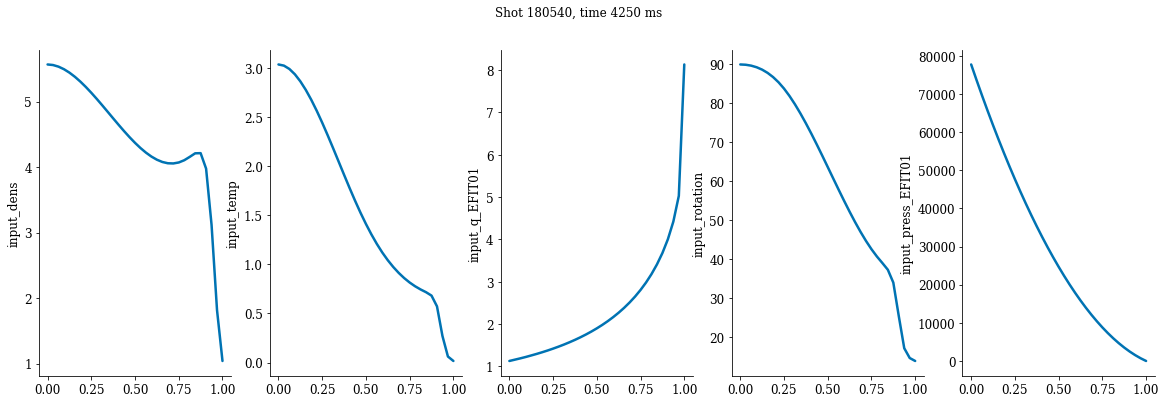

In [28]:
index = np.random.randint(len(train_generator))
foo = copy.deepcopy(train_generator[index][0])
initial_state = {'input_'+profile: foo['input_'+profile] for profile in scenario['input_profile_names']}
initial_parameters = {'input_'+sig: foo['input_'+ sig] for sig in scenario['scalar_input_names']}
control_input = {'input_past_'+sig: foo['input_past_'+ sig] for sig in scenario['actuator_names']}

shotnum = train_generator.cur_shotnum[0,0]
shottime = train_generator.cur_times[0,-scenario['lookahead']-1]

psi = np.linspace(0,1,33)
profiles = [key.split('_')[-1] for key in initial_state.keys()]
fig, ax = plt.subplots(1,len(profiles),figsize=(20,6))
for i, profile in enumerate(initial_state.keys()):
    arr = helpers.normalization.denormalize(initial_state[profile].squeeze(), scenario['normalization_dict'][profile[6:]])
    ax[i].plot(psi,arr)
    ax[i].set_ylabel(profile)
    fig.suptitle("Shot {}, time {} ms".format(int(shotnum), int(shottime)))


In [24]:
lookahead=4
iterations=10
outputs = predict_with_feedback(model,initial_state, initial_parameters, control_input, lookahead, iterations,kernels,2)

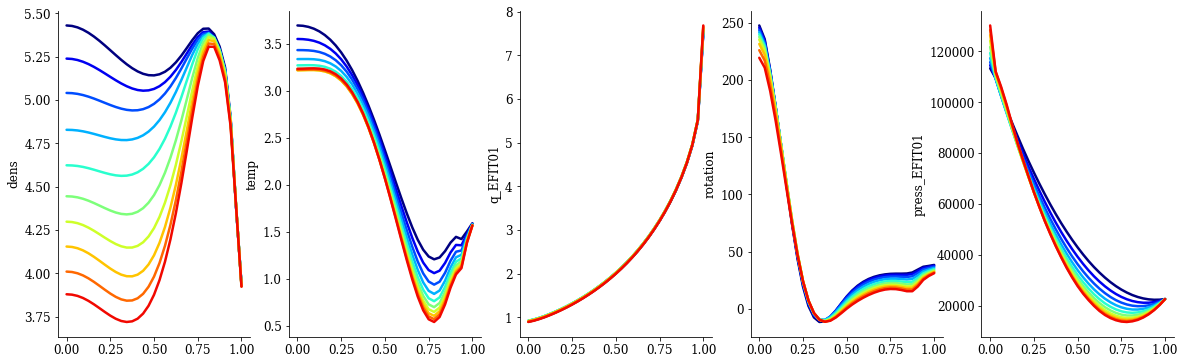

In [26]:
psi = np.linspace(0,1,33)
profiles = [key.split('_')[-1] for key in initial_state.keys()]
j=iterations-1
fig, ax = plt.subplots(1,len(outputs.keys()),figsize=(20,6))
cmap = plt.cm.jet
for j in range(0,iterations):
    for i, profile in enumerate(outputs.keys()):
        arr = helpers.normalization.denormalize(outputs[profile][j,:], scenario['normalization_dict'][profile])
        ax[i].plot(psi,arr, c=cmap(int(j/iterations*cmap.N)))
#         ax[i].plot(psi,initial_state['input_'+profile].squeeze(),c='r')
        ax[i].set_ylabel(profile)